In [26]:
import pandas as pd

def split_csv_by_column(input_file, column_name, output_folder):
    """
    Splits a CSV file into multiple CSVs based on unique values in a specified column.

    Parameters:
        input_file (str): Path to the input CSV file.
        column_name (str): Name of the column to split on.
        output_folder (str): Folder to save the output CSV files.
    """
    # Load the CSV file
    data = pd.read_csv(input_file)

    # Check if the column exists
    if column_name not in data.columns:
        raise ValueError(f"Column '{column_name}' not found in the CSV file.")

    # Get unique values in the specified column
    unique_values = data[column_name].unique()

    # Create and save a separate CSV for each unique value
    for value in unique_values:
        # Filter the data for the current value
        filtered_data = data[data[column_name] == value]

        # Generate the output file name
        output_file = f"{output_folder}/{value}.csv"

        # Save the filtered data to a CSV file
        filtered_data.to_csv(output_file, index=False)
        print(f"Saved file: {output_file}")

# Example usage
input_csv = "/content/Data.csv"
output_dir = "/content/Dataset"
column_to_split = "experiment_tag"  # Column to split on

# Ensure the output folder exists
import os
os.makedirs(output_dir, exist_ok=True)

# Split the CSV
split_csv_by_column(input_csv, column_to_split, output_dir)

Saved file: /content/Dataset/c1.csv
Saved file: /content/Dataset/c4.csv
Saved file: /content/Dataset/c6.csv


In [27]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

def import_data(file_path):
  # Load the dataset to examine its structure
  data = pd.read_csv(file_path)

  # Display the first few rows of the dataset to understand its structure
  data.head(), data.info()

  # Remove the original indexing and the dataset tag
  data_cleaned = data.drop(columns=['Unnamed: 0', 'dataset_tag', 'experiment_tag'])

  # Use the timestamp as the new indexing
  data_cleaned.set_index('timestamp', inplace=True)

  # Scale the numeric columns
  scaler = StandardScaler()
  numeric_columns = ['force_x', 'force_y', 'force_z', 'vibration_x', 'vibration_y', 'vibration_z', 'acoustic_emission_rms', 'tool_wear']
  data_cleaned[numeric_columns] = scaler.fit_transform(data_cleaned[numeric_columns])

  return data_cleaned

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34722 entries, 0 to 34721
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             34722 non-null  int64  
 1   force_x                34722 non-null  float64
 2   force_y                34722 non-null  float64
 3   force_z                34722 non-null  float64
 4   vibration_x            34722 non-null  float64
 5   vibration_y            34722 non-null  float64
 6   vibration_z            34722 non-null  float64
 7   acoustic_emission_rms  34722 non-null  float64
 8   timestamp              34722 non-null  float64
 9   tool_wear              34722 non-null  float64
 10  experiment_tag         34722 non-null  object 
 11  dataset_tag            34722 non-null  object 
dtypes: float64(9), int64(1), object(2)
memory usage: 3.2+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34674 entries, 0 to 34673
Data columns (total 12 co

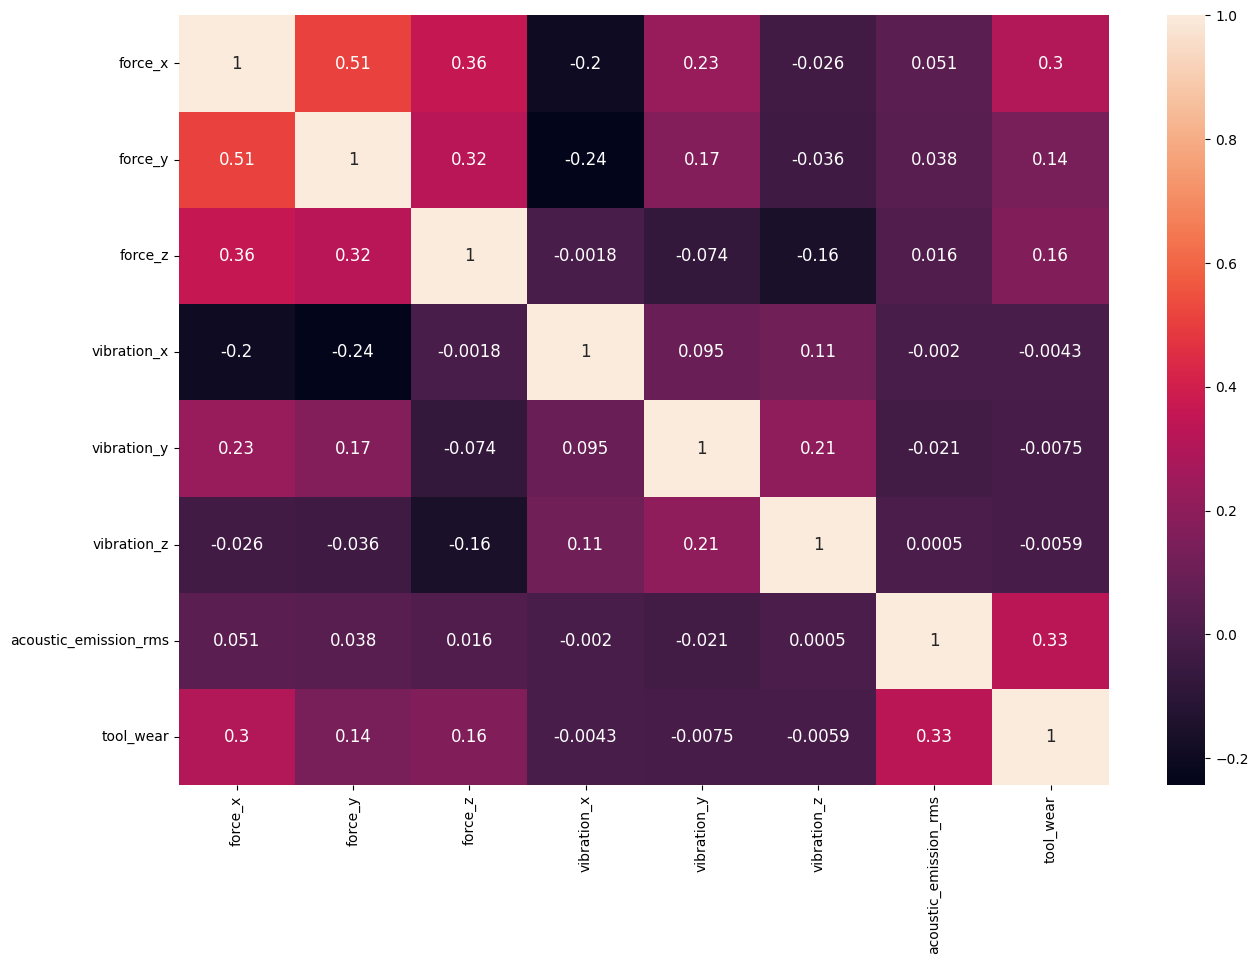

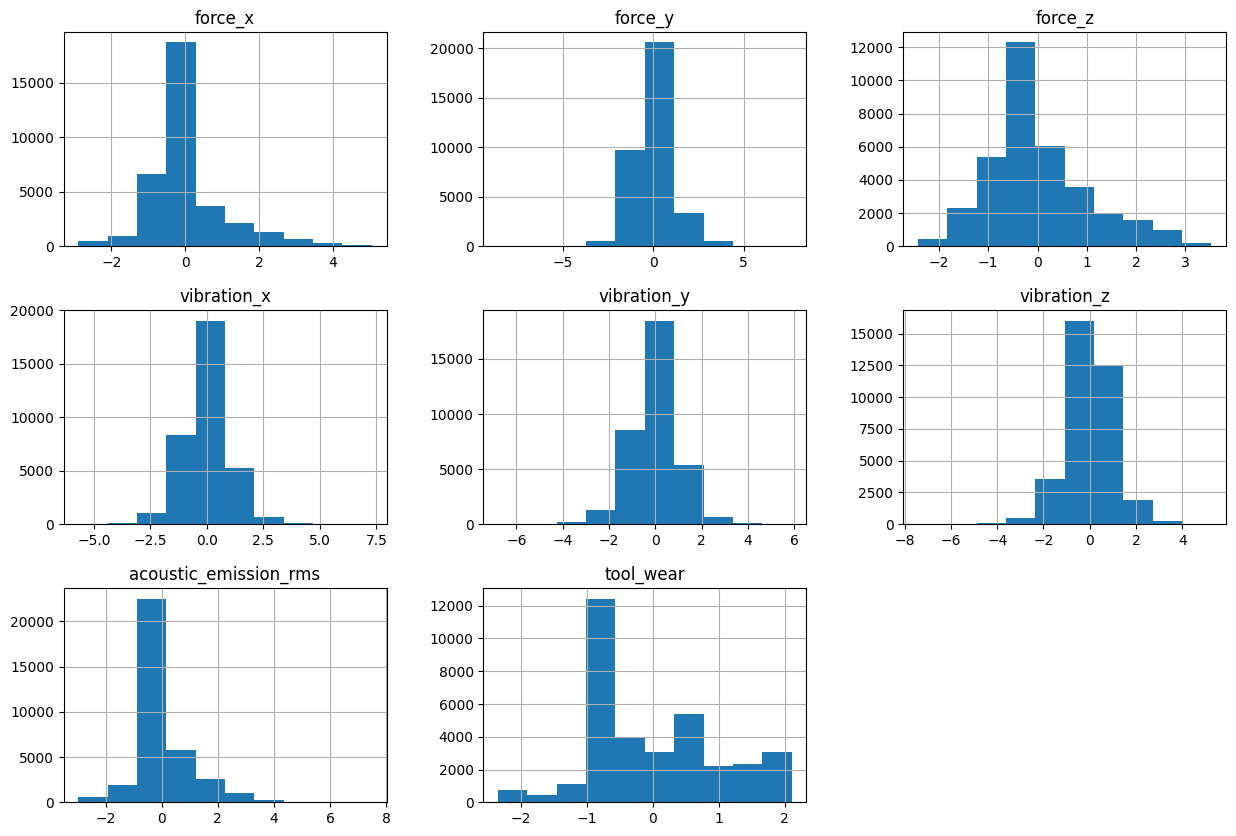

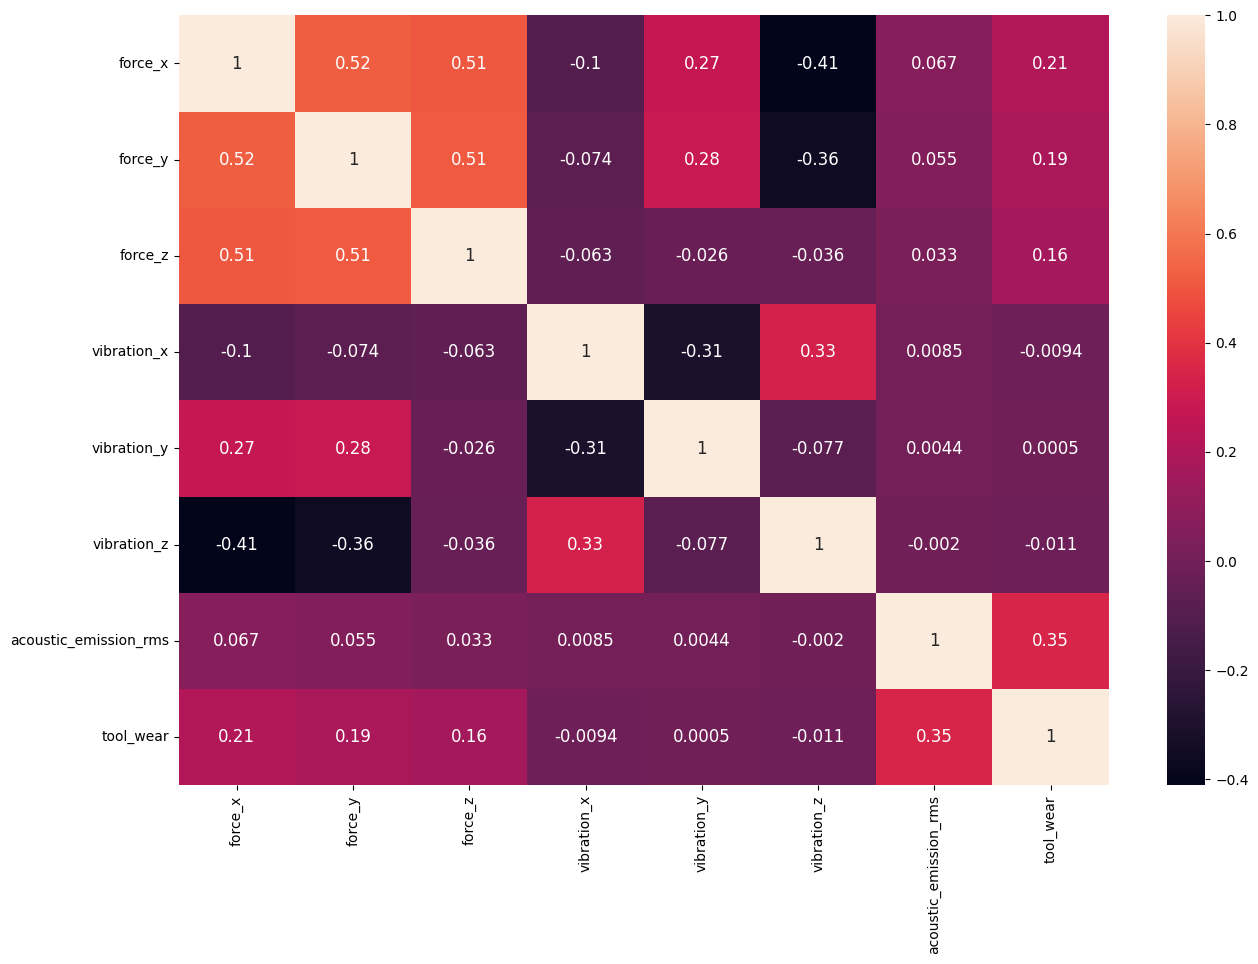

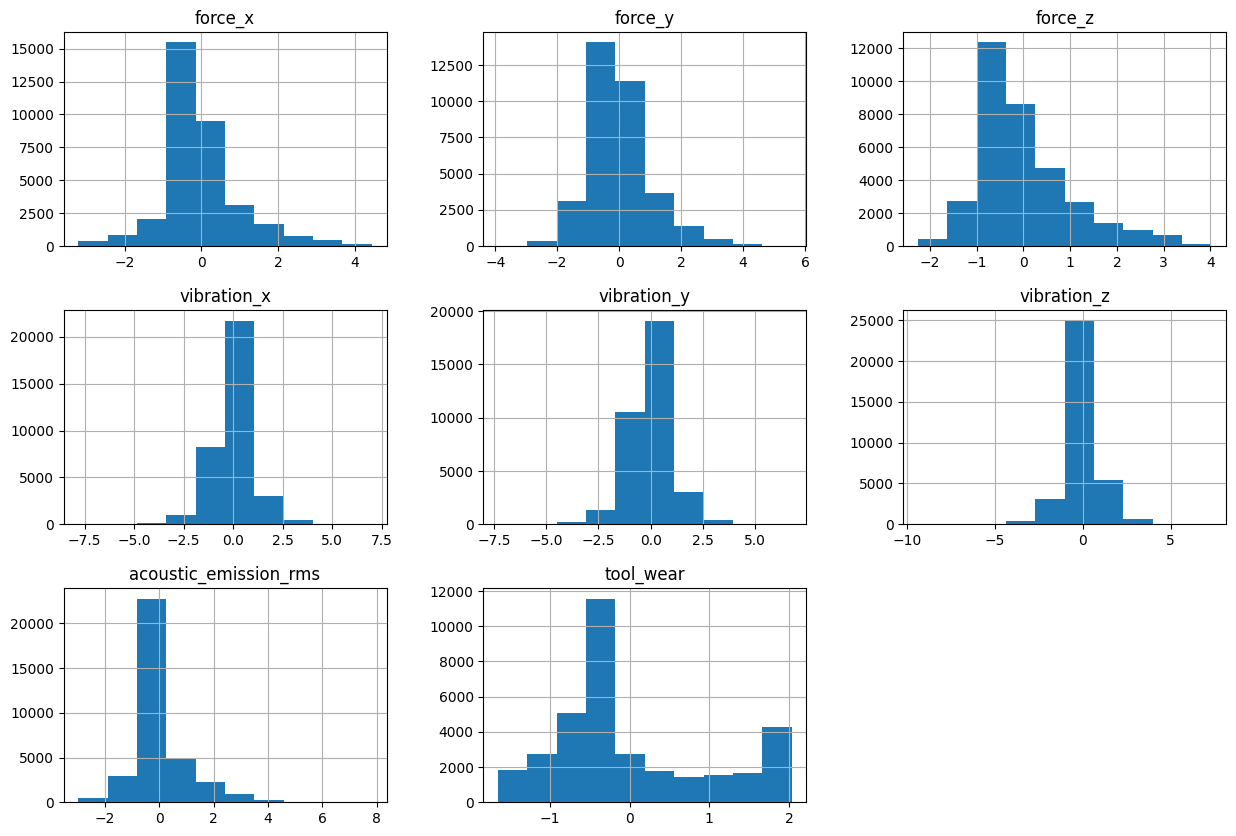

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

def EDA(data_cleaned):
  plt.figure(figsize = (15,10))
  sns.heatmap(data_cleaned.corr(), annot = True, annot_kws = {"size":12})

  data_cleaned.hist(figsize=(15,10))

train_data = import_data("/content/Dataset/c1.csv")
test_data = import_data("/content/Dataset/c6.csv")

EDA(train_data)
EDA(test_data)

In [29]:
# run_repeats.py
import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras import Input
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score
from scipy import stats

# ---------- Utilities ----------
def set_seed(seed):
    """Set global random seeds. Pass None to skip (unseeded run)."""
    if seed is None:
        return
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

def create_sequences(features, target, time_steps=10):
    Xs, ys = [], []
    for i in range(len(features) - time_steps):
        Xs.append(features[i:(i + time_steps)])
        ys.append(target[i + time_steps])
    return np.array(Xs), np.array(ys)

def build_model(time_steps, n_features, lstm_units=64, dense_units=32, dropout_rate=0.2):
    model = Sequential([
        Input(shape=(time_steps, n_features)),
        LSTM(lstm_units, activation='tanh'),
        Dropout(dropout_rate),
        Dense(dense_units, activation='relu'),
        Dense(1, activation='linear')
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

def t_confidence_interval(data, alpha=0.05):
    a = np.array(data, dtype=float)
    n = len(a)
    mean = a.mean()
    if n > 1:
        se = a.std(ddof=1) / np.sqrt(n)
        h = stats.t.ppf(1 - alpha/2, n - 1) * se
    else:
        se = 0.0
        h = 0.0
    return mean, a.std(ddof=1) if n>1 else 0.0, (mean - h, mean + h), n

# ---------- User: supply train_data and test_data DataFrames ----------
# The original script used `train_data` and `test_data`. Ensure they exist.
# Example:
# train_data = pd.read_csv("train.csv")
# test_data  = pd.read_csv("test.csv")

assert 'train_data' in globals(), "Please provide `train_data` DataFrame in the environment."
assert 'test_data' in globals(), "Please provide `test_data` DataFrame in the environment."

# ---------- Configuration ----------
time_steps = 10
lstm_units = 64
dense_units = 32
dropout_rate = 0.20
batch_size = 32
epochs = 100
patience = 10  # early stopping patience
seeds = [None, 42, 69, 100]  # None -> original unseeded run

# ---------- Prepare sequences (temporal) ----------
X_train_raw = train_data.drop(columns=['tool_wear']).values
y_train_raw = train_data['tool_wear'].values
X_test_raw  = test_data.drop(columns=['tool_wear']).values
y_test_raw  = test_data['tool_wear'].values

X_train_seq, y_train_seq = create_sequences(X_train_raw, y_train_raw, time_steps)
X_test_seq,  y_test_seq  = create_sequences(X_test_raw,  y_test_raw,  time_steps)

# Temporal split within train_seq: 85% train / 15% val (preserves order)
split_idx = int(len(X_train_seq) * 0.85)
X_tr, y_tr = X_train_seq[:split_idx], y_train_seq[:split_idx]
X_val, y_val = X_train_seq[split_idx:], y_train_seq[split_idx:]

n_features = X_tr.shape[2]

# ---------- Run experiments ----------
results = []
detailed = []

for s in seeds:
    print(f"\n=== RUN seed={s} ===")
    # Reset graph and set seed
    tf.keras.backend.clear_session()
    if s is not None:
        set_seed(s)
    else:
        # explicit skip: leave randomness as-is for original unseeded run
        pass

    model = build_model(time_steps, n_features, lstm_units, dense_units, dropout_rate)

    es = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True, verbose=1)

    history = model.fit(
        X_tr, y_tr,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        shuffle=False,      # preserve temporal order
        callbacks=[es],
        verbose=1
    )

    # Evaluate and collect metrics
    test_eval = model.evaluate(X_test_seq, y_test_seq, verbose=0)
    test_mse = float(test_eval[0])
    test_mae = float(test_eval[1])

    y_pred = model.predict(X_test_seq, verbose=0).reshape(-1)
    r2 = float(r2_score(y_test_seq, y_pred))

    print(f"Seed {s} -> Test MSE: {test_mse:.6f}, Test MAE: {test_mae:.6f}, R2: {r2:.6f}")

    results.append({'seed': 'unseeded' if s is None else int(s),
                    'test_mse': test_mse,
                    'test_mae': test_mae,
                    'r2': r2})
    # Save history final best metrics optionally
    detailed.append({
        'seed': 'unseeded' if s is None else int(s),
        'history_last_epoch': history.history,
        'test_mse': test_mse,
        'test_mae': test_mae,
        'r2': r2
    })

# ---------- Save per-run results ----------
results_df = pd.DataFrame(results)
results_df.to_csv('results_runs.csv', index=False)
pd.DataFrame(detailed).to_pickle('results_runs_detailed.pkl')

# ---------- Aggregate statistics ----------
mse_vals = results_df['test_mse'].values
mae_vals = results_df.loc[results_df['seed'] != 'unseeded', 'test_mae'].values  # follow your paper: MAE & R2 from seeded runs
r2_vals  = results_df.loc[results_df['seed'] != 'unseeded', 'r2'].values

mse_mean, mse_std, mse_ci, mse_n = t_confidence_interval(mse_vals)
mae_mean, mae_std, mae_ci, mae_n = t_confidence_interval(mae_vals)
r2_mean, r2_std, r2_ci, r2_n = t_confidence_interval(r2_vals)

agg = {
    'metric': ['test_mse', 'test_mae', 'r2'],
    'mean': [mse_mean, mae_mean, r2_mean],
    'std':  [mse_std, mae_std, r2_std],
    '95% CI low': [mse_ci[0], mae_ci[0], r2_ci[0]],
    '95% CI high':[mse_ci[1], mae_ci[1], r2_ci[1]],
    'n': [mse_n, mae_n, r2_n]
}
agg_df = pd.DataFrame(agg)
agg_df.to_csv('aggregated_metrics.csv', index=False)

# ---------- Print summary for copy-paste into paper ----------
print("\n--- Aggregated metrics ---")
print(agg_df.to_string(index=False, float_format='%.6f'))

print("\nReady: saved per-run results -> results_runs.csv and aggregated -> aggregated_metrics.csv")



=== RUN seed=None ===
Epoch 1/100
923/923 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.3865 - mae: 0.3183 - val_loss: 0.4158 - val_mae: 0.5767
Epoch 2/100
923/923 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.3255 - mae: 0.2314 - val_loss: 0.2850 - val_mae: 0.4725
Epoch 3/100
923/923 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.6249 - mae: 0.3098 - val_loss: 0.2992 - val_mae: 0.4847
Epoch 4/100
923/923 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.6726 - mae: 0.3278 - val_loss: 0.2864 - val_mae: 0.4643
Epoch 5/100
923/923 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.8042 - mae: 0.3821 - val_loss: 0.3063 - val_mae: 0.4810
Epoch 6/100
923/923 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.7791 - mae: 0.3455 - val_loss: 0.2824 - val_mae: 0.4707
Epoch 7/100
923/923 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.4799 - mae: 0.2726 - val_loss: 0.2871 - val_mae: 0.4511
Epoch 8/100
923/923 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.5612 - mae: 0.3014 - val_loss: 0.3104 - val_mae: 0.4932
Epoch 9/100
923/923 ━━━━━

Training Loss (MSE): 2.5237, Training MAE: 1.3988
Testing Loss (MSE): 2.5376, Testing MAE: 1.4305
R^2 Score on Test Data: -1.5389


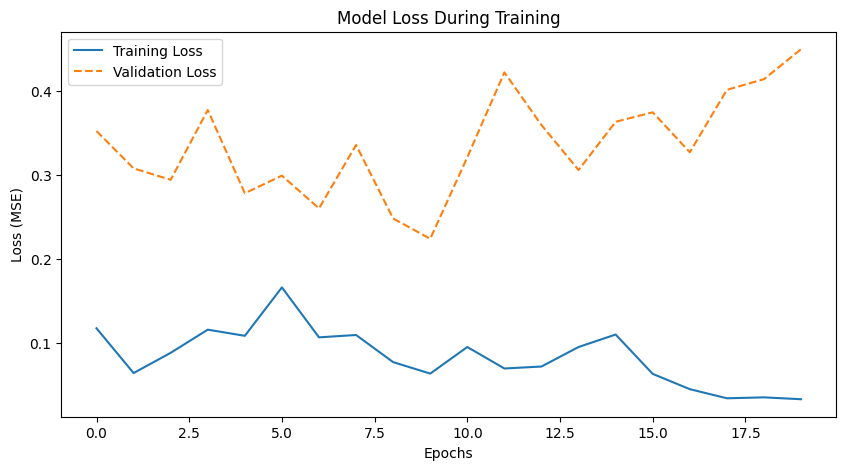

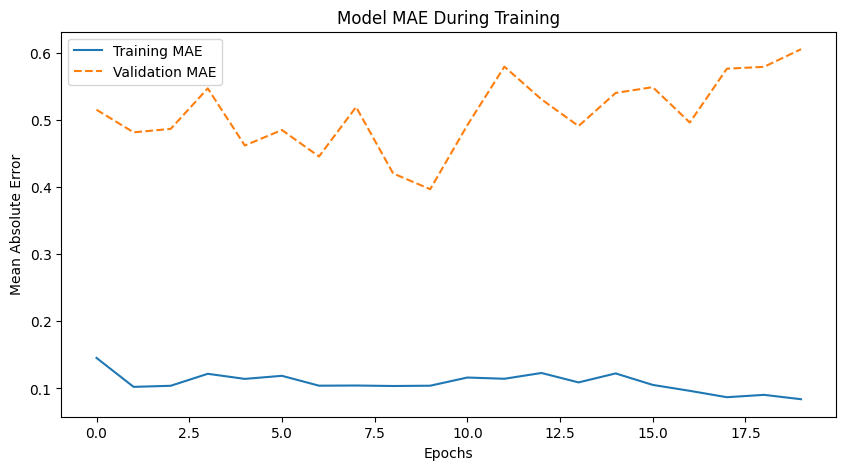

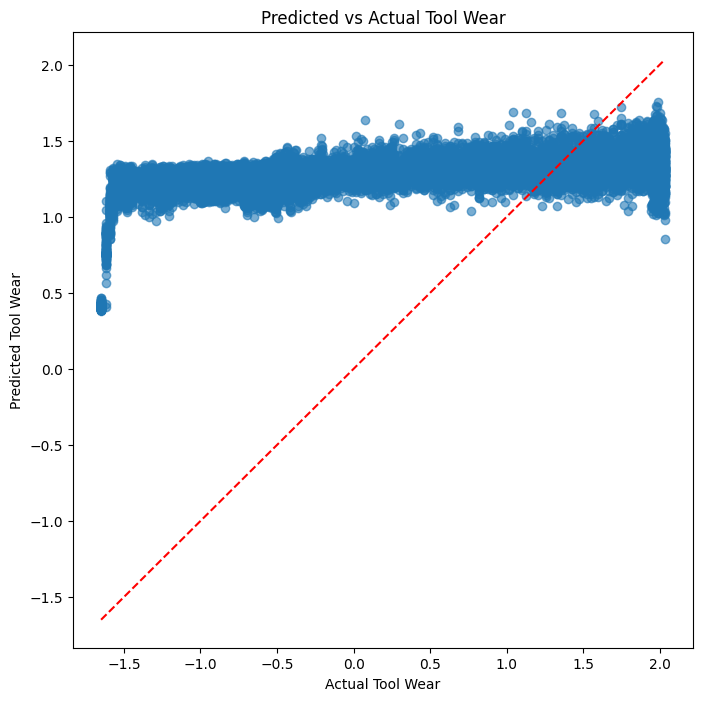

In [30]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

# 1. Evaluate the Model on Training and Testing Data
train_loss, train_mae = model.evaluate(X_train, y_train, verbose=0)
test_loss, test_mae = model.evaluate(X_test, y_test, verbose=0)

print(f"Training Loss (MSE): {train_loss:.4f}, Training MAE: {train_mae:.4f}")
print(f"Testing Loss (MSE): {test_loss:.4f}, Testing MAE: {test_mae:.4f}")

# 2. Compute R^2 Score
r2 = r2_score(y_test, y_pred)
print(f"R^2 Score on Test Data: {r2:.4f}")

# 3. Plot Training and Validation Loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss', linestyle='--')
plt.title('Model Loss During Training')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()

# 4. Plot Training and Validation MAE
plt.figure(figsize=(10, 5))
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE', linestyle='--')
plt.title('Model MAE During Training')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.show()

# 5. Visualize Predictions vs Actual Values
plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.title('Predicted vs Actual Tool Wear')
plt.xlabel('Actual Tool Wear')
plt.ylabel('Predicted Tool Wear')
plt.show()


In [31]:
import joblib

# Save the model
joblib.dump(model, 'model.pkl')


['model.pkl']

In [32]:
# Flatten each sequence into a single row.
X_test_flat = X_test.reshape(X_test.shape[0], -1)

# Convert the NumPy array to a pandas DataFrame.
df = pd.DataFrame(X_test_flat)

# Save the DataFrame to a CSV file.
df.to_csv('test.csv', index=False)